# **<center>Spotify Music Analysis</center>**

## **By**
- Sushil Saindane

## **Project Overview**

This project analyzes music data from Spotify and Genius to gain insights into song characteristics, popularity, and lyrical content. I've developed a comprehensive pipeline that includes:

1. **Data Collection:**
   - Utilized Spotify API to gather track metadata and audio features
   - Scraped lyrics from Genius using their API

2. **Data Integration:**
   - Combined Spotify track data with corresponding lyrics
   - Created a rich dataset with musical, popularity, and lyrical information

3. **Analysis Objectives:**
   - **Popularity Prediction:** Built a model to forecast a song's potential popularity
   - **Content-based Recommendation:** Developed a system to suggest similar songs based on audio features and lyrics
   - **Summary Generation:** Produced concise summaries of song lyrics using advanced NLP techniques
   - **Sentiment Analysis:** Categorized songs into various moods based on lyrical content

In [23]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


## Song Popularity Prediction Model

This script implements an ensemble model to predict song popularity:

- **Data**: Uses features like tempo, energy, loudness, and artist metrics
- **Preprocessing**: Handles missing values and scales features
- **Model**: Ensemble of Linear Regression, Ridge Regression, and Random Forest
- **Evaluation**: Achieves R-squared of 0.87 and MAE of 3.00
- **Example**: Predicts popularity of 78.58 for "PILLOWTALK" (actual: 79)

The model demonstrates strong predictive performance for track popularity based on audio features and artist metrics.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_excel('master_final.xlsx')

# Display basic information about the dataset
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Feature selection
features = ['Tempo', 'Danceability', 'Energy', 'Instrumentalness', 'Acousticness', 
            'Speechiness', 'Valence', 'Loudness', 'Artist Followers', 'Popularity Score', 
            'Monthly Listeners', 'Composite_Score']
X = df[features]
y = df['Track_Popularity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Create the ensemble model
lr = LinearRegression()
ridge = Ridge(alpha=1.0)
rf = RandomForestRegressor(n_estimators=100, random_state=42)

ensemble = VotingRegressor(
    estimators=[('lr', lr), ('ridge', ridge), ('rf', rf)],
    weights=[1, 1, 2]
)

# Train the model
ensemble.fit(X_train_scaled, y_train)

# Make predictions
y_pred = ensemble.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Mean Absolute Error: {mae}")

# Example prediction
example_song = X_test.iloc[0]
example_song_imputed = imputer.transform([example_song])
example_song_scaled = scaler.transform(example_song_imputed)
predicted_popularity = ensemble.predict(example_song_scaled)[0]
actual_popularity = y_test.iloc[0]

print(f"Example Song: {df['Title'].iloc[X_test.index[0]]}")
print(f"Predicted Popularity: {predicted_popularity:.2f}")
print(f"Actual Popularity: {actual_popularity}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3229 entries, 0 to 3228
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               3229 non-null   object 
 1   Artist              3229 non-null   object 
 2   Album               3228 non-null   object 
 3   Release_Date        3229 non-null   object 
 4   Available_Markets   2864 non-null   object 
 5   Genre               3180 non-null   object 
 6   ISRC                3229 non-null   object 
 7   Lyrics              3229 non-null   object 
 8   Tempo               3229 non-null   float64
 9   Key                 3229 non-null   int64  
 10  Mode                3229 non-null   int64  
 11  Danceability        3229 non-null   float64
 12  Energy              3229 non-null   float64
 13  Instrumentalness    3229 non-null   float64
 14  Acousticness        3229 non-null   float64
 15  Speechiness         3229 non-null   float64
 16  Valenc

C:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


## Content-based (Item-Item) Recommendation System

This script implements a content-based recommendation system for songs using:

- Numerical features: Tempo, Danceability, Energy, etc.
- Categorical features: Genre, Key, Mode
- Lyrics: Processed using TF-IDF

Key steps:
1. Data preprocessing and feature engineering
2. Feature combination using numerical, categorical, and text data
3. Similarity computation using cosine similarity and sigmoid kernel
4. Recommendation function to suggest similar songs

Example output shows top 10 recommendations using both similarity measures for the song "Disease", both models having similar recommendations.



In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, sigmoid_kernel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Load the dataset
df = pd.read_excel('master_final.xlsx')

# Data Preprocessing
df = df.dropna()
df = df.drop_duplicates()

# Convert Release_Date to numerical feature (days since a reference date)
df['Release_Date'] = pd.to_datetime(df['Release_Date'])
reference_date = df['Release_Date'].min()
df['Days_Since_Release'] = (df['Release_Date'] - reference_date).dt.days

# Identify numerical and categorical features
numerical_features = ['Tempo', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence', 'Days_Since_Release']
categorical_features = ['Genre', 'Key', 'Mode']

# Standardization of Numerical Features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# One-hot encoding for categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

# Text features to vector form (TF-IDF)
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Lyrics'].fillna(''))

# Ensure all feature matrices have the same number of rows
min_rows = min(df.shape[0], encoded_features.shape[0], tfidf_matrix.shape[0])
df = df.iloc[:min_rows]
encoded_features = encoded_features[:min_rows]
tfidf_matrix = tfidf_matrix[:min_rows]

# Combine all features
feature_matrix = np.hstack((
    df[numerical_features].values,
    encoded_features,
    tfidf_matrix.toarray()
))

# Impute any remaining NaN values
imputer = SimpleImputer(strategy='mean')
feature_matrix = imputer.fit_transform(feature_matrix)

# Compute Cosine Similarity
cosine_sim = cosine_similarity(feature_matrix)

# Compute Sigmoid Kernel
sigmoid_sim = sigmoid_kernel(feature_matrix)

# Function to get recommendations
def get_recommendations(title, similarity_matrix, df, top_n=10):
    idx = df.index[df['Title'] == title].tolist()[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    song_indices = [i[0] for i in sim_scores]
    return df['Title'].iloc[song_indices]

# Example usage
song_title = "Disease"  # Replace with any song title from your dataset
print("Cosine Similarity Recommendations:")
print(get_recommendations(song_title, cosine_sim, df))
print("\nSigmoid Kernel Recommendations:")
print(get_recommendations(song_title, sigmoid_sim, df))


Cosine Similarity Recommendations:
2010    I'm With The Band (feat. Beck)
2962        Chronograph (English Ver.)
2394                  SKIN OF MY TEETH
1978                    Fourth Of July
2691                    Can't Be Tamed
1952                          Anywhere
2551                      Kaikai Kitan
2507                           Propose
730                            So What
1221                My Head & My Heart
Name: Title, dtype: object

Sigmoid Kernel Recommendations:
2010    I'm With The Band (feat. Beck)
2394                  SKIN OF MY TEETH
2765         Louder (feat. Sian Evans)
1978                    Fourth Of July
2298                            Encore
2962        Chronograph (English Ver.)
2497                 Never Be the Same
1862                    Play That Song
521                   Bring Me To Life
2507                           Propose
Name: Title, dtype: object


## Lyrics Summarization with Flan-T5-small

This script generates concise summaries for song lyrics using the Flan-T5-small model:

- Loads lyrics data from 'master_final.xlsx'
- Utilizes Flan-T5-small for text summarization
- Processes lyrics in batches of 64 for efficiency
- Adds generated summaries as a new column
- Saves updated dataset back to 'master_final.xlsx'

Key metrics:
- Processed 3229 unique songs from the dataset.

In [51]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
import torch
from tqdm import tqdm

# Load the dataset
df = pd.read_excel('master_final.xlsx')

# Initialize a faster pre-trained model and tokenizer (Flan-T5-small)
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Function to generate summaries in batches
def generate_summaries_batch(batch):
    inputs = tokenizer(
        ["summarize: " + text for text in batch["Lyrics"]],
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128,
    ).to(device)
    outputs = model.generate(
        inputs["input_ids"],
        max_length=50,
        num_beams=3,
        early_stopping=True,
    )
    summaries = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return summaries

# Process dataset in batches with a progress bar
batch_size = 64
all_summaries = []

for i in tqdm(range(0, len(df), batch_size), desc="Generating Summaries"):
    batch = df.iloc[i:i + batch_size]
    summaries = generate_summaries_batch(batch)
    all_summaries.extend(summaries)

# Add the generated summaries to the dataset
df['generated_summary'] = all_summaries

# Save the updated dataset
df.to_excel('master_final.xlsx', index=False)

print(f"Summarization completed for {len(df)} observations.")


Generating Summaries: 100%|██████████| 51/51 [23:55<00:00, 28.14s/it]


Summarization completed for 3229 observations.


## Sentiment Analysis and Visualization

This script performs sentiment analysis on song lyrics summaries and creates various visualizations:

1. Loads data and initializes sentiment analysis pipeline
2. Calculates sentiment scores and categories
3. Generates visualizations:
   - Sentiment score distribution
   - Average sentiment by genre
   - Sentiment trends over time
   - Track popularity by sentiment
   - Track popularity by genre and sentiment
   - Sentiment trends by genre over time
   - Track popularity by sentiment over time
   - Overall sentiment trends

Key features:
- Uses DistilBERT model for sentiment analysis
- Creates 8 different visualizations using matplotlib and seaborn
- Analyzes sentiment trends across genres and time periods

The below script provides comprehensive insights into sentiment patterns in music lyrics and their relationship with popularity and genre.


Device set to use cpu


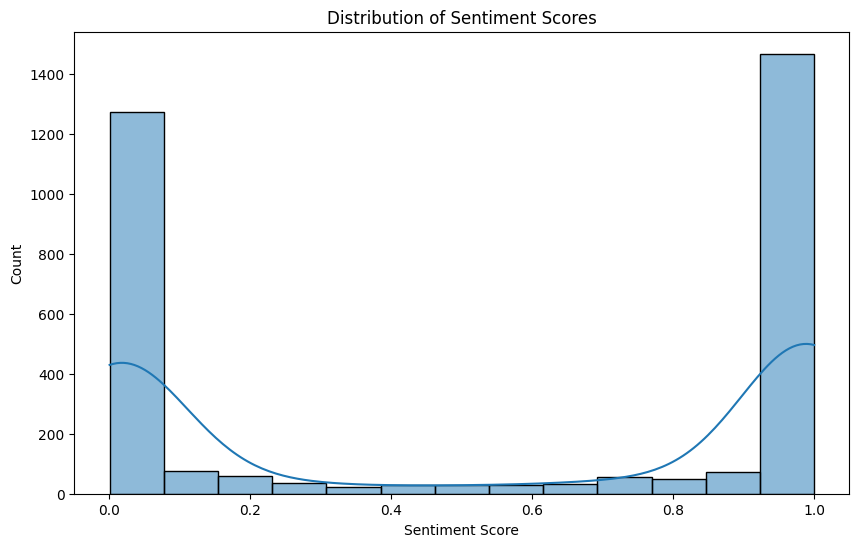

C:\Users\User\AppData\Local\Temp\ipykernel_20724\1723109600.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


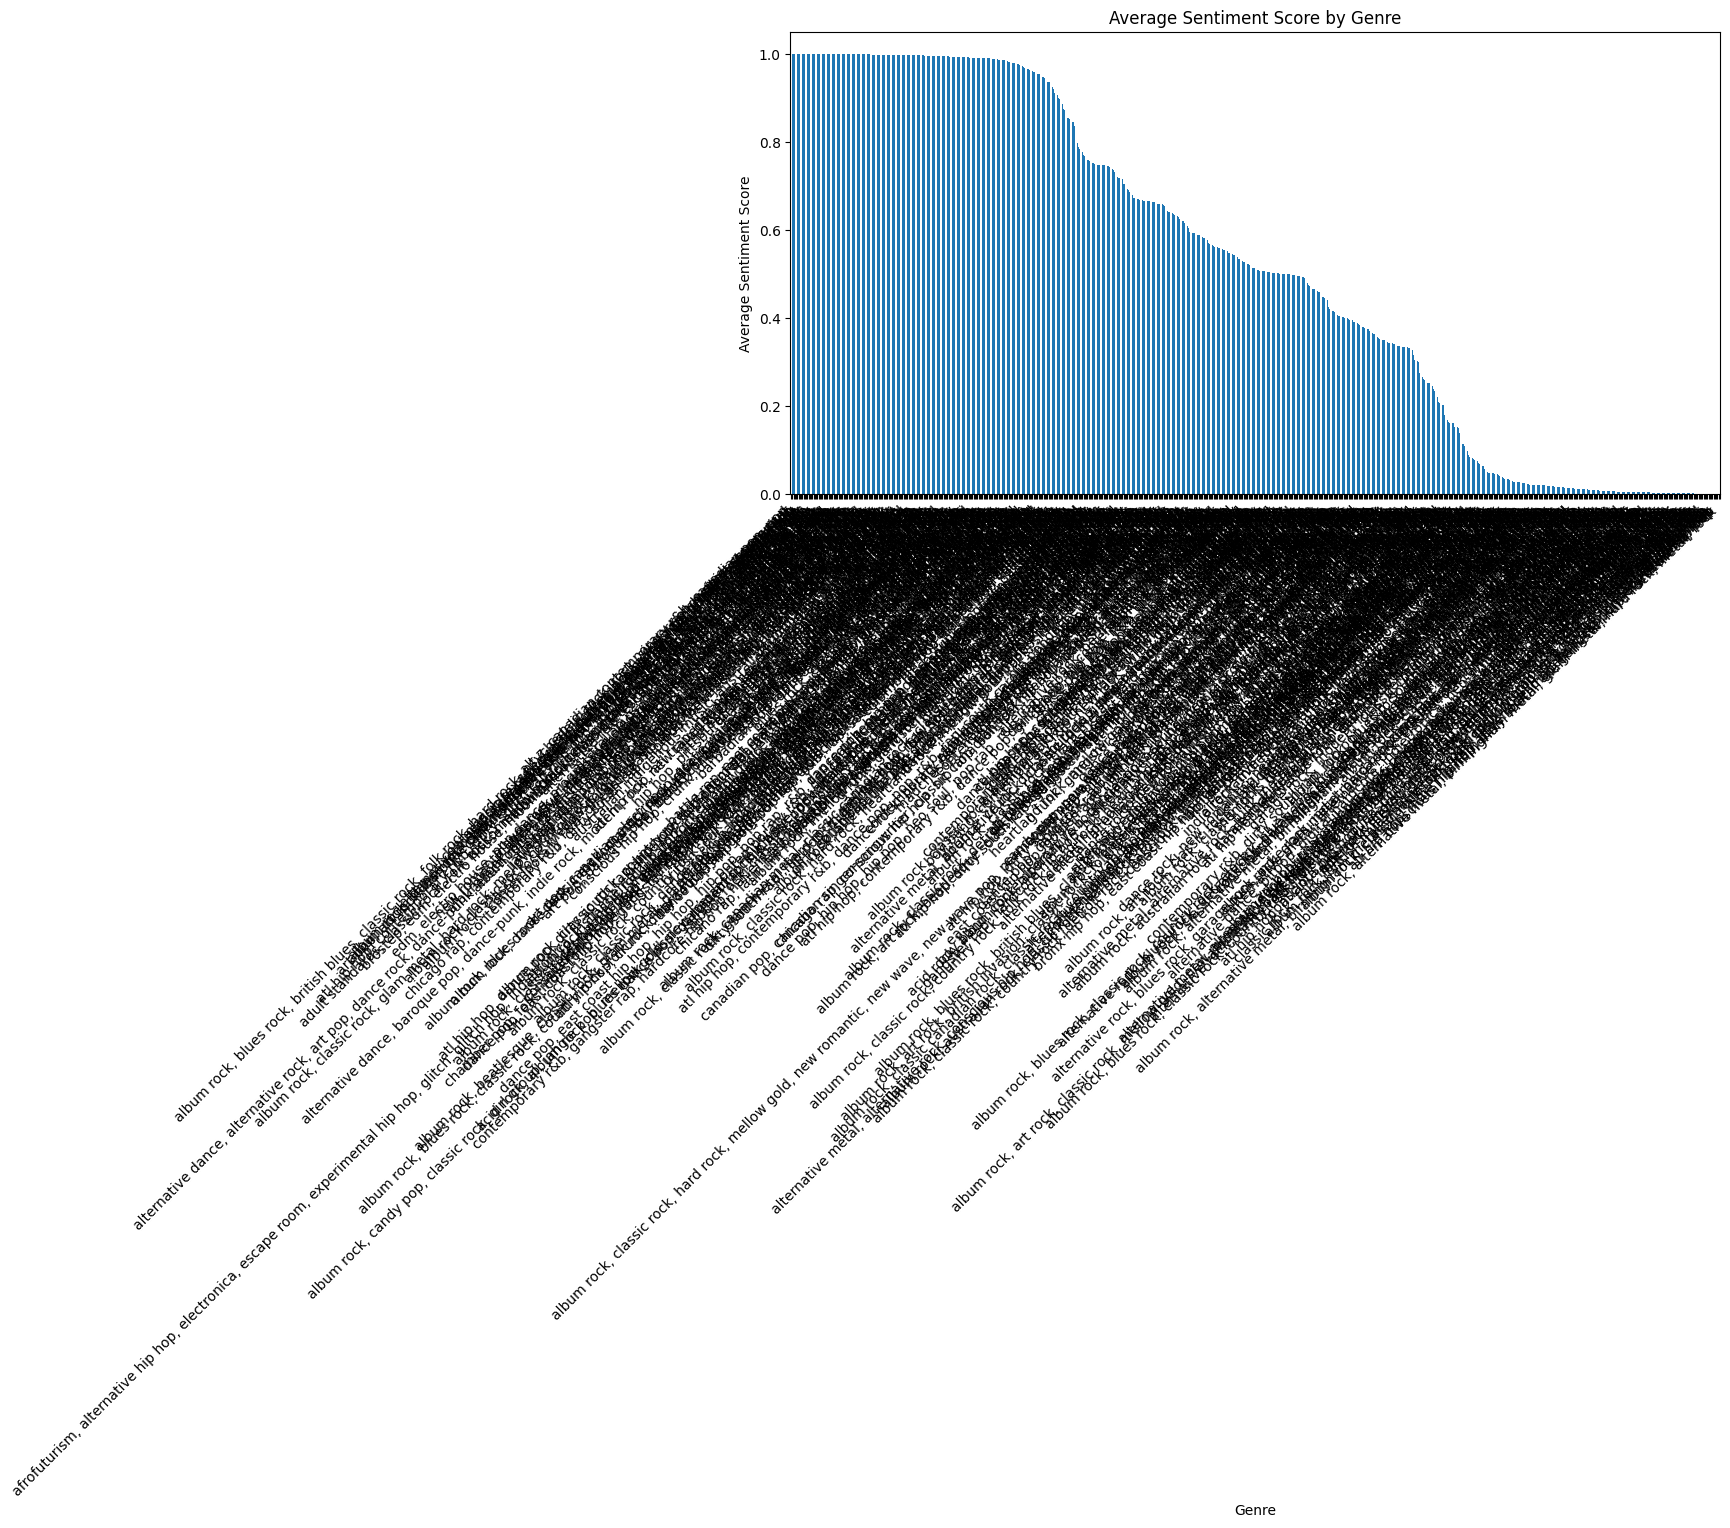

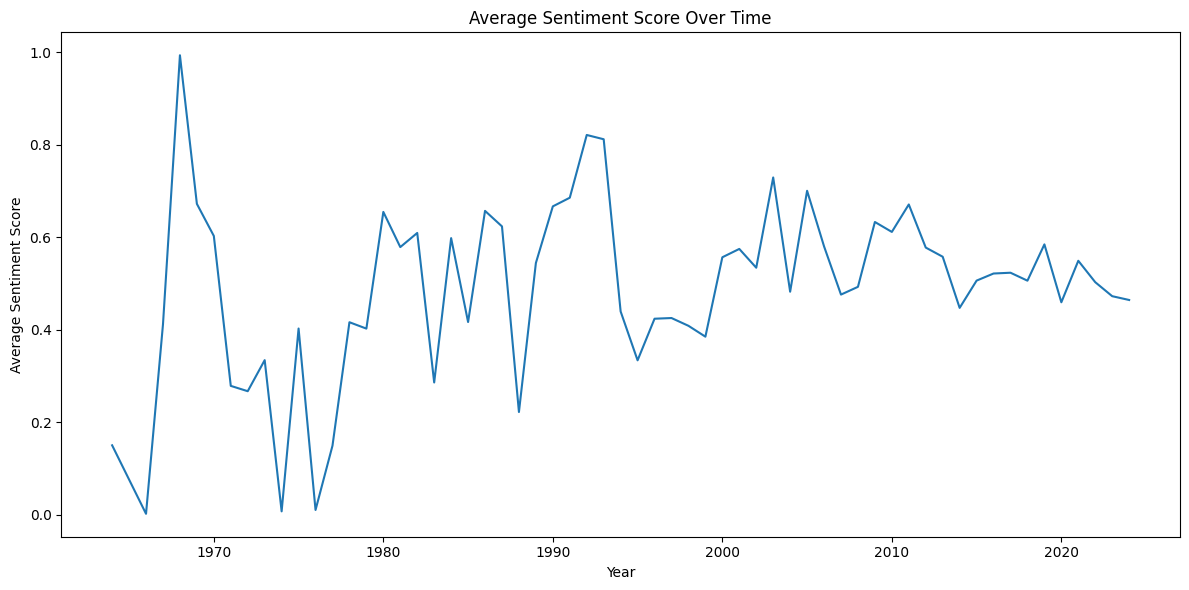

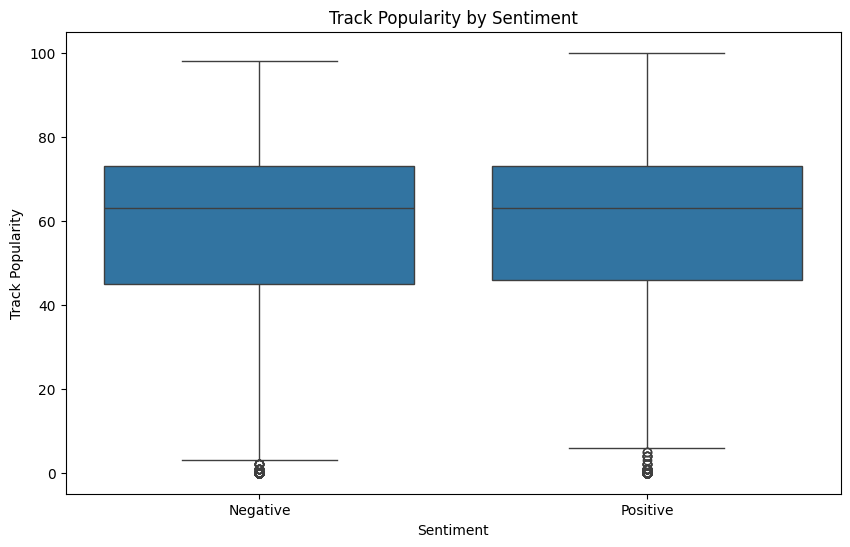

C:\Users\User\AppData\Local\Temp\ipykernel_20724\1723109600.py:73: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_20724\1723109600.py:73: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


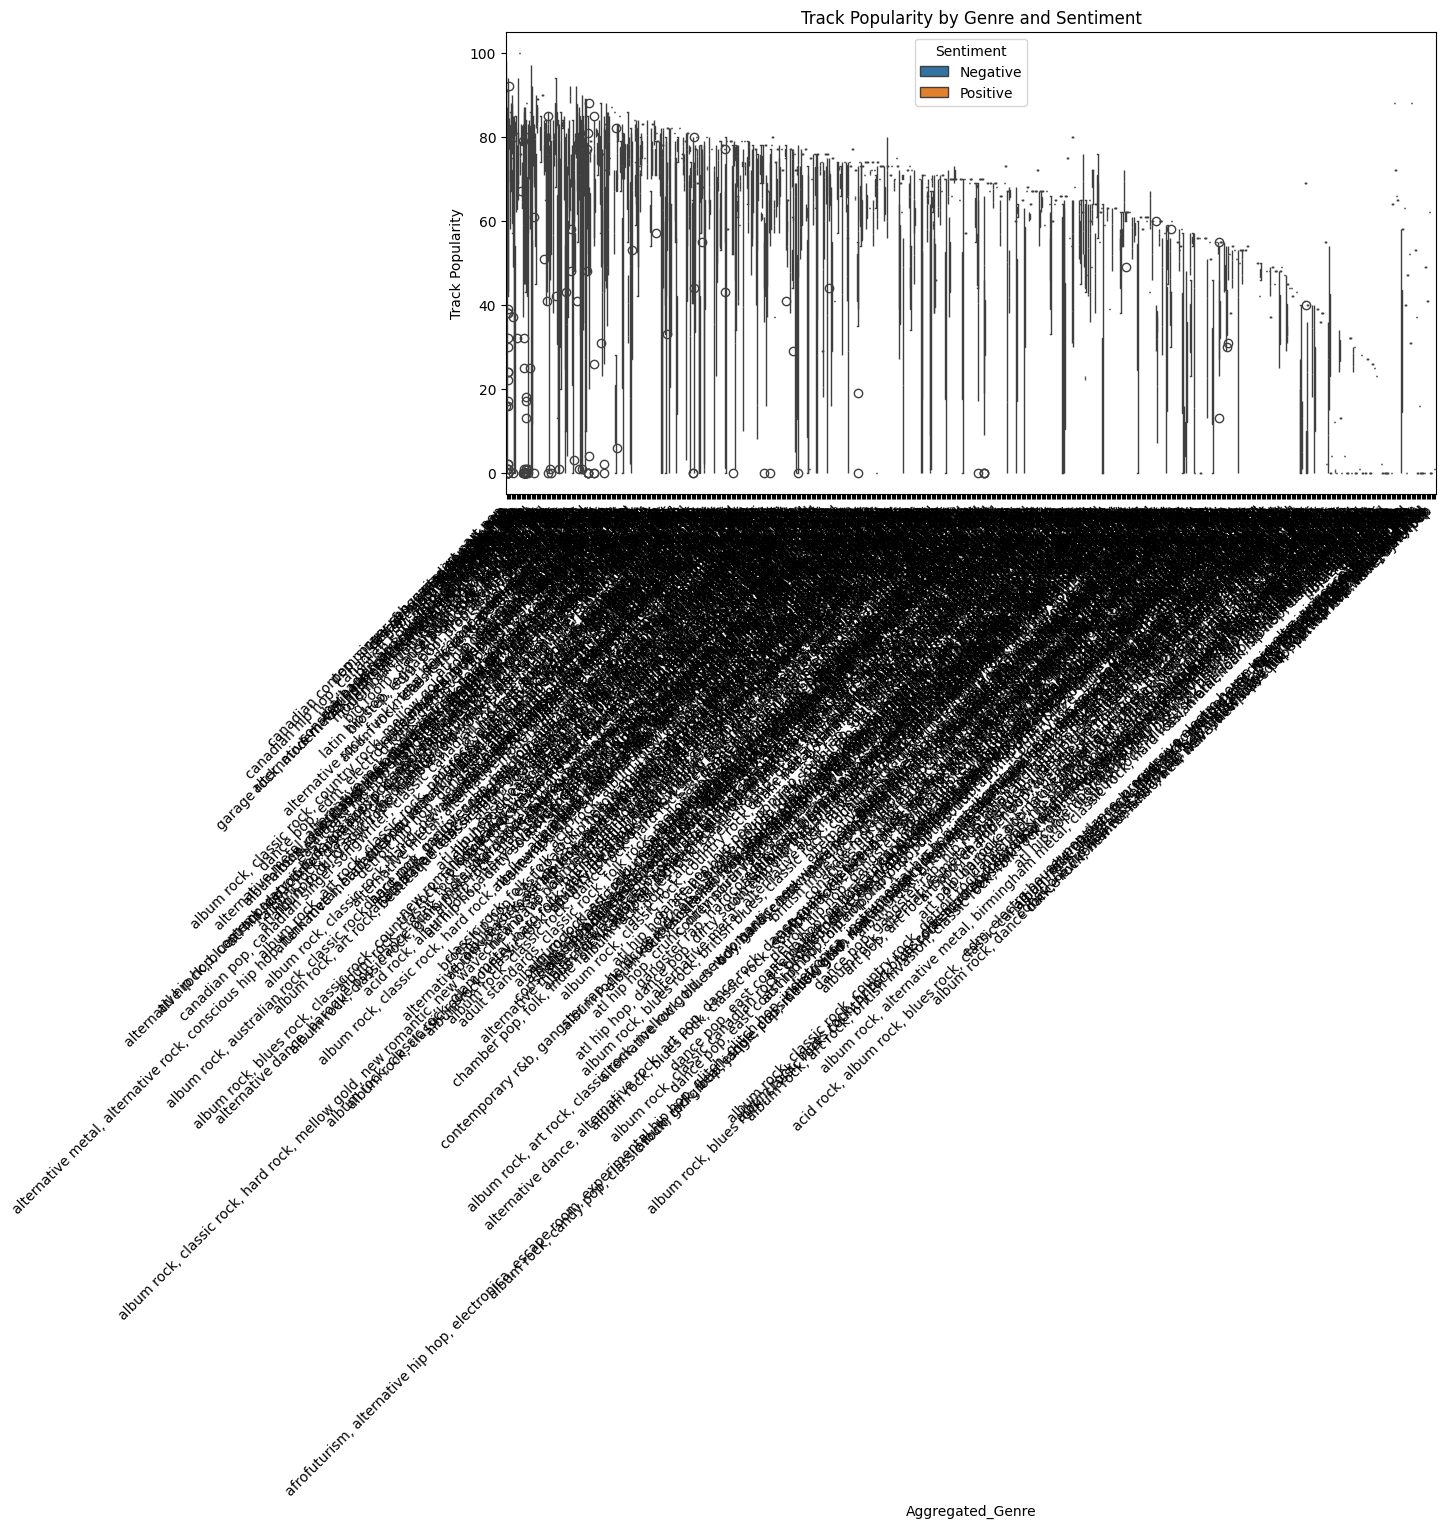

<Figure size 1200x600 with 0 Axes>

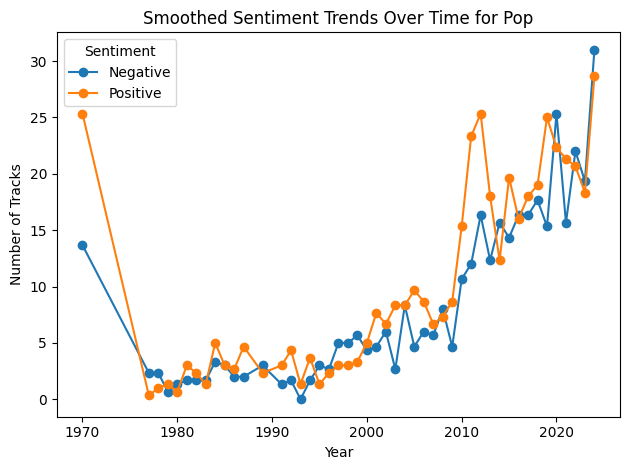

<Figure size 1200x600 with 0 Axes>

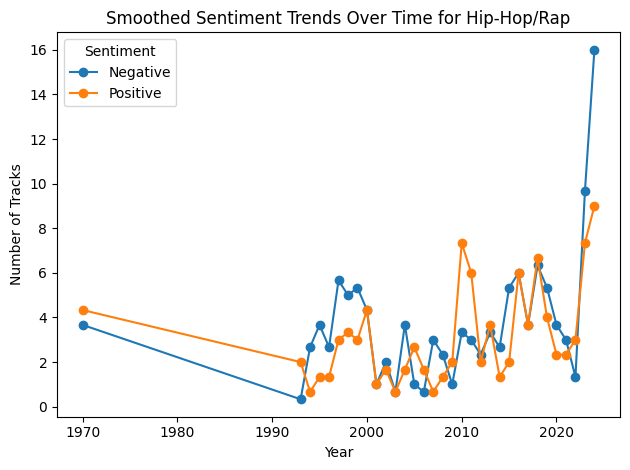

<Figure size 1200x600 with 0 Axes>

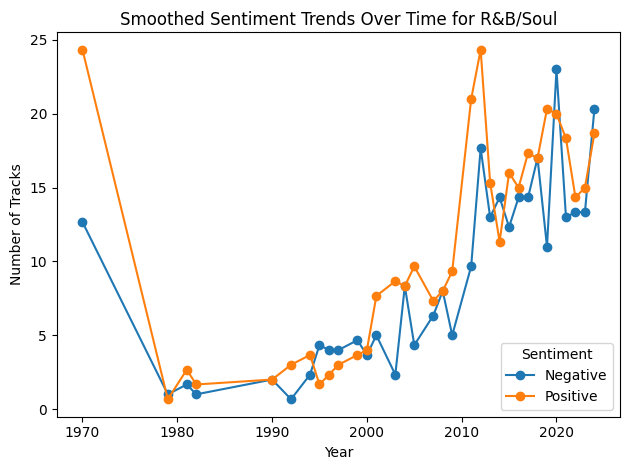

<Figure size 1200x600 with 0 Axes>

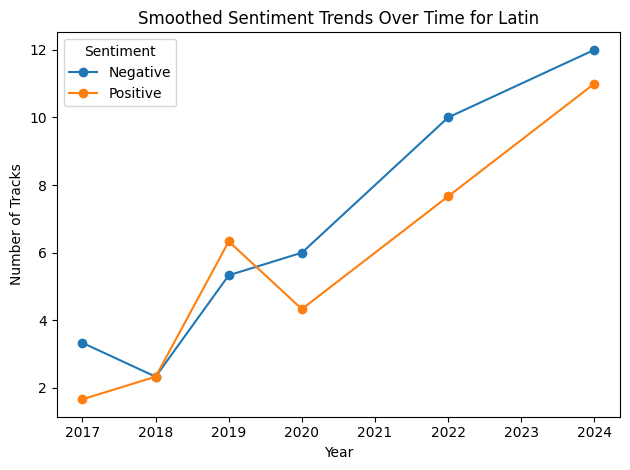

<Figure size 1200x600 with 0 Axes>

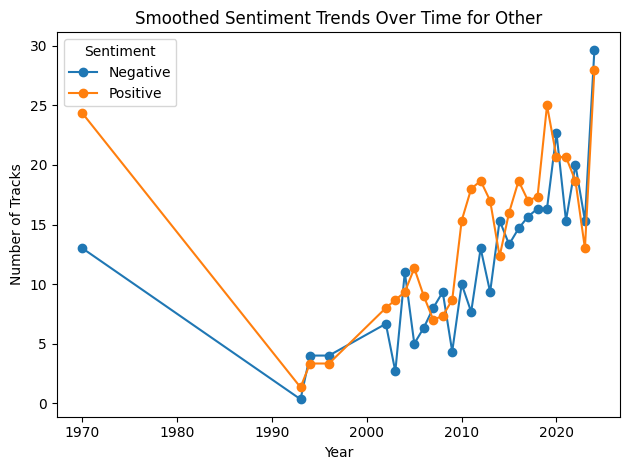

<Figure size 1200x600 with 0 Axes>

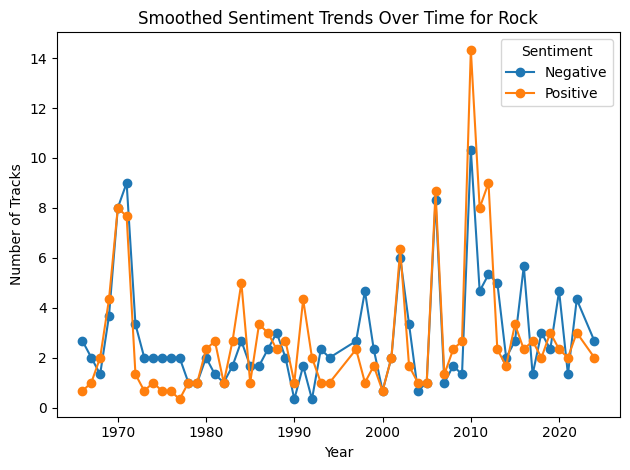

<Figure size 1200x600 with 0 Axes>

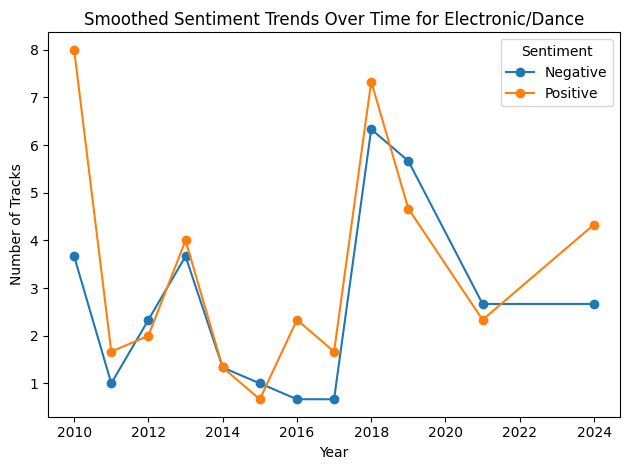

<Figure size 1200x600 with 0 Axes>

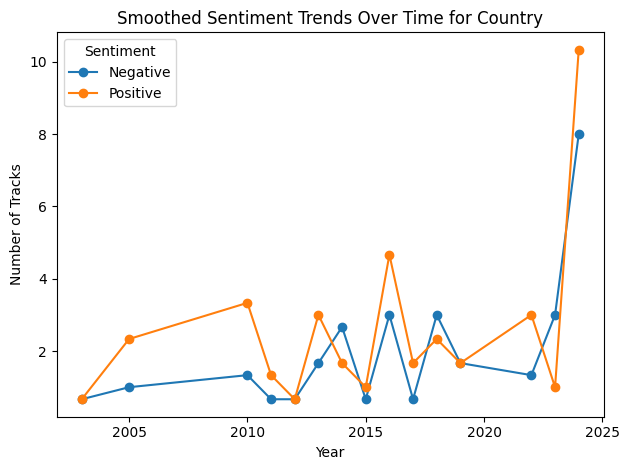

<Figure size 1200x600 with 0 Axes>

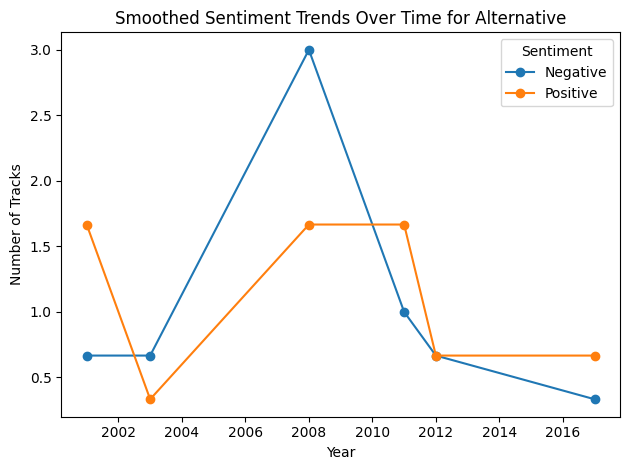

<Figure size 1200x600 with 0 Axes>

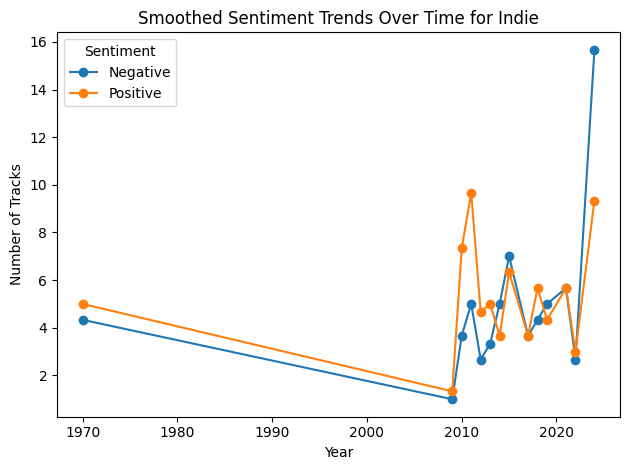

<Figure size 1200x600 with 0 Axes>

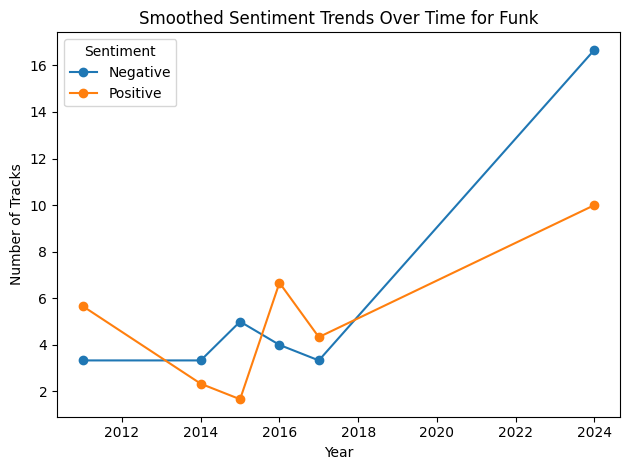

<Figure size 1200x600 with 0 Axes>

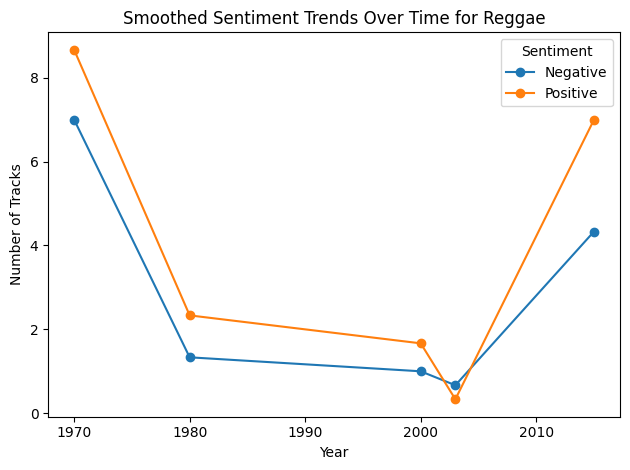

<Figure size 1200x600 with 0 Axes>

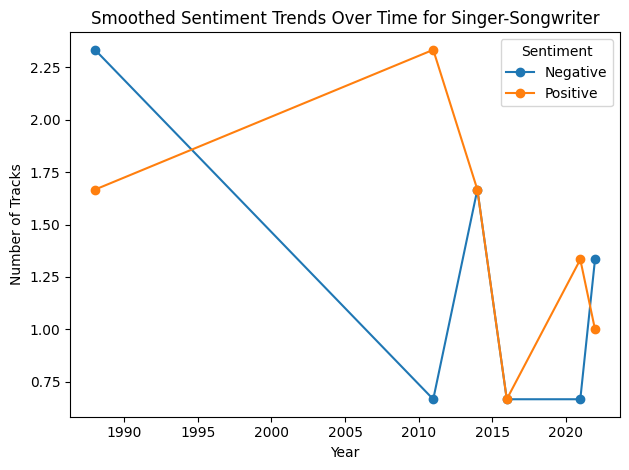

<Figure size 1200x600 with 0 Axes>

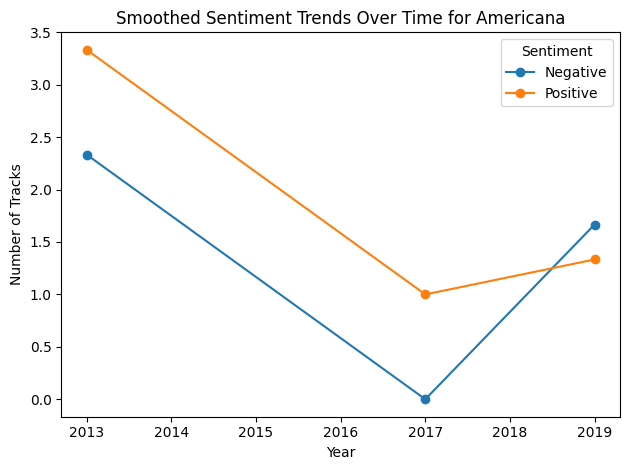

<Figure size 1200x600 with 0 Axes>

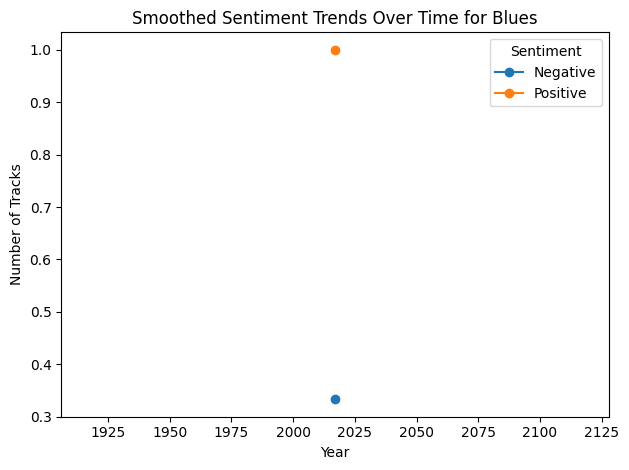

<Figure size 1200x600 with 0 Axes>

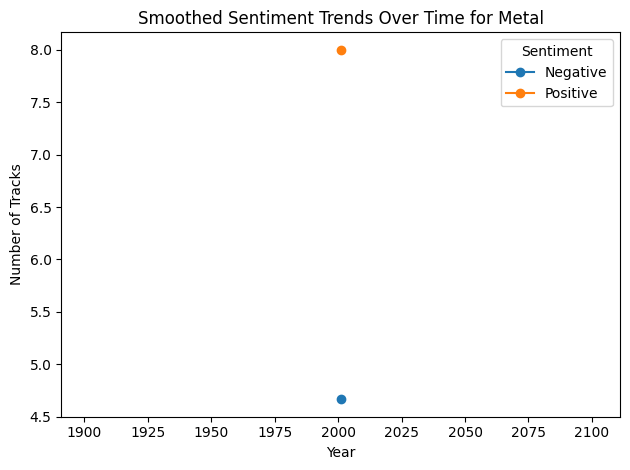

<Figure size 1200x600 with 0 Axes>

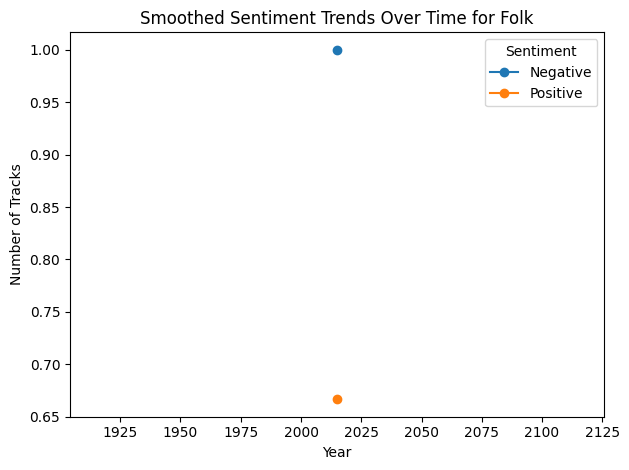

<Figure size 1200x600 with 0 Axes>

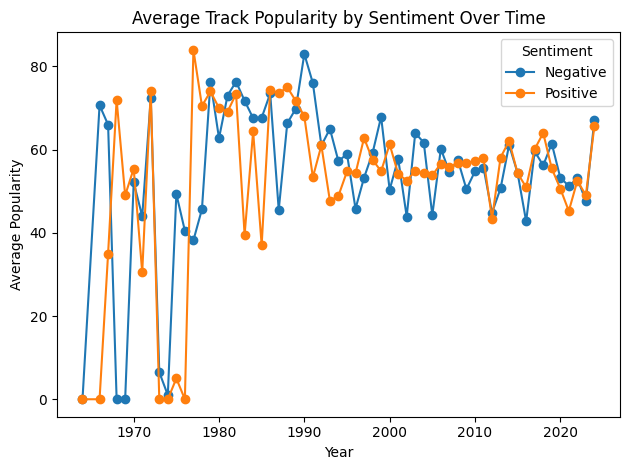

<Figure size 1200x600 with 0 Axes>

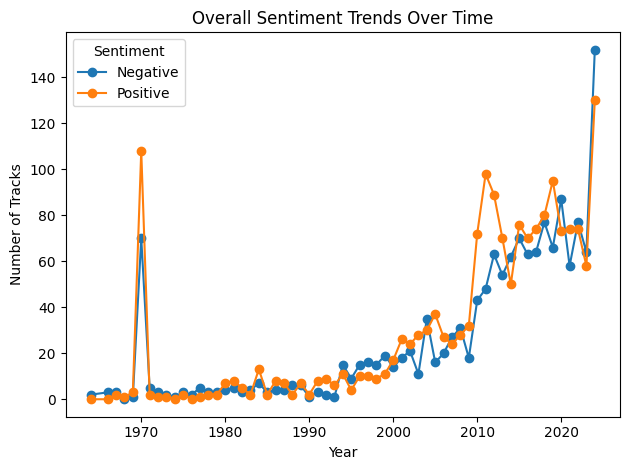

Sentiment analysis and visualizations completed.


In [53]:
import pandas as pd
import numpy as np
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset with summaries
df = pd.read_excel('master_final.xlsx')

# Initialize sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to get sentiment scores
def get_sentiment_score(text):
    result = sentiment_pipeline(text[:512])[0]  # Limit text length to 512 tokens
    return result['score'] if result['label'] == 'POSITIVE' else 1 - result['score']

# Apply sentiment analysis to summaries
df['sentiment_score'] = df['generated_summary'].apply(get_sentiment_score)

# Add sentiment category
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'Positive' if x > 0.5 else 'Negative')

# Convert Release_Date to datetime and extract year
df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce')
df['Release_Year'] = df['Release_Date'].dt.year

# Visualization 1: Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment_score'], kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

# Visualization 2: Average Sentiment by Genre
genre_sentiment = df.groupby('Genre')['sentiment_score'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
genre_sentiment.plot(kind='bar')
plt.title('Average Sentiment Score by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization 3: Sentiment Over Time
yearly_sentiment = df.groupby('Release_Year')['sentiment_score'].mean()
plt.figure(figsize=(12, 6))
yearly_sentiment.plot(kind='line')
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.tight_layout()
plt.show()

# Visualization 4: Boxplot to visualize popularity by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='Track_Popularity', data=df)
plt.title('Track Popularity by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Track Popularity')
plt.show()

# Visualization 5: Track Popularity By Genre and Sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='Track_Popularity', hue='sentiment', data=df)
plt.title('Track Popularity by Genre and Sentiment')
plt.xlabel('Aggregated_Genre')
plt.ylabel('Track Popularity')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# Visualization 6: Sentiment Trends Over Time by Genre
df['broad_genre'] = df['Aggregated_Genre'].apply(lambda x: x.split()[0] if isinstance(x, str) else 'Unknown')
sentiment_trends = df.groupby(['Release_Year', 'broad_genre', 'sentiment']).size().unstack(fill_value=0)
sentiment_trends_rolling = sentiment_trends.rolling(window=3, center=True).mean()

for genre in df['broad_genre'].unique():
    if genre in sentiment_trends.index.get_level_values(1):
        genre_data = sentiment_trends_rolling.xs(genre, level='broad_genre')
        plt.figure(figsize=(12, 6))
        genre_data.plot(kind='line', marker='o')
        plt.title(f"Smoothed Sentiment Trends Over Time for {genre}")
        plt.xlabel("Year")
        plt.ylabel("Number of Tracks")
        plt.legend(title="Sentiment")
        plt.tight_layout()
        plt.show()

# Visualization 7: Average Track Popularity by Sentiment Over Time
popularity_trends = df.groupby(['Release_Year', 'sentiment'])['Track_Popularity'].mean().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
popularity_trends.plot(kind='line', marker='o')
plt.title("Average Track Popularity by Sentiment Over Time")
plt.xlabel("Year")
plt.ylabel("Average Popularity")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# Visualization 8: Overall Sentiment Trends Over Time
overall_trends = df.groupby(['Release_Year', 'sentiment']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
overall_trends.plot(kind='line', marker='o')
plt.title("Overall Sentiment Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Tracks")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

print("Sentiment analysis and visualizations completed.")


## Mood Categorization and Analysis

The below script performs the following tasks:

1. Sentiment Analysis: Uses NLTK's VADER to analyze lyrics sentiment
2. Topic Modeling: Applies LDA to identify 5 main topics in lyrics
3. Clustering: Combines audio features, sentiment, and topics for K-means clustering
4. Mood Assignment: Maps clusters to predefined mood labels
5. Playlist Generation: Creates playlists based on moods
6. Visualization: Plots mood distribution and mood vs. popularity

Key features:
- Uses sklearn for topic modeling and clustering
- Generates pretty-printed playlists
- Creates visualizations using matplotlib and seaborn
- Saves results to Excel file

The script provides comprehensive mood analysis and categorization for a music dataset.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Happy and Upbeat Playlist:
+----------------------+---------------+-----------------------+
| Title                | Artist        | Album                 |
+----------------------+---------------+-----------------------+
| ocean eyes           | Billie Eilish | dont smile at me      |
| Shake It Off         | Taylor Swift  | 1989 (Deluxe)         |
| Heartless            | The Weeknd    | After Hours           |
| A Sky Full of Stars  | Coldplay      | Ghost Stories         |
| Night Changes        | One Direction | FOUR (Deluxe)         |
| Hymn for the Weekend | Coldplay      | A Head Full of Dreams |
| Talking to the Moon  | Bruno Mars    | Doo-Wops & Hooligans  |
| Disease              | Lady Gaga     | Disease               |
| Alone Again          | The Weeknd    | After Hours           |
| Saturn               | SZA           | Saturn                |
+----------------------+---------------+-----------------------+

Sad and Melancholic Playlist:
+------------------------------

C:\Users\User\AppData\Local\Temp\ipykernel_20724\3917359776.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mood_counts.index, y=mood_counts.values, palette="viridis")


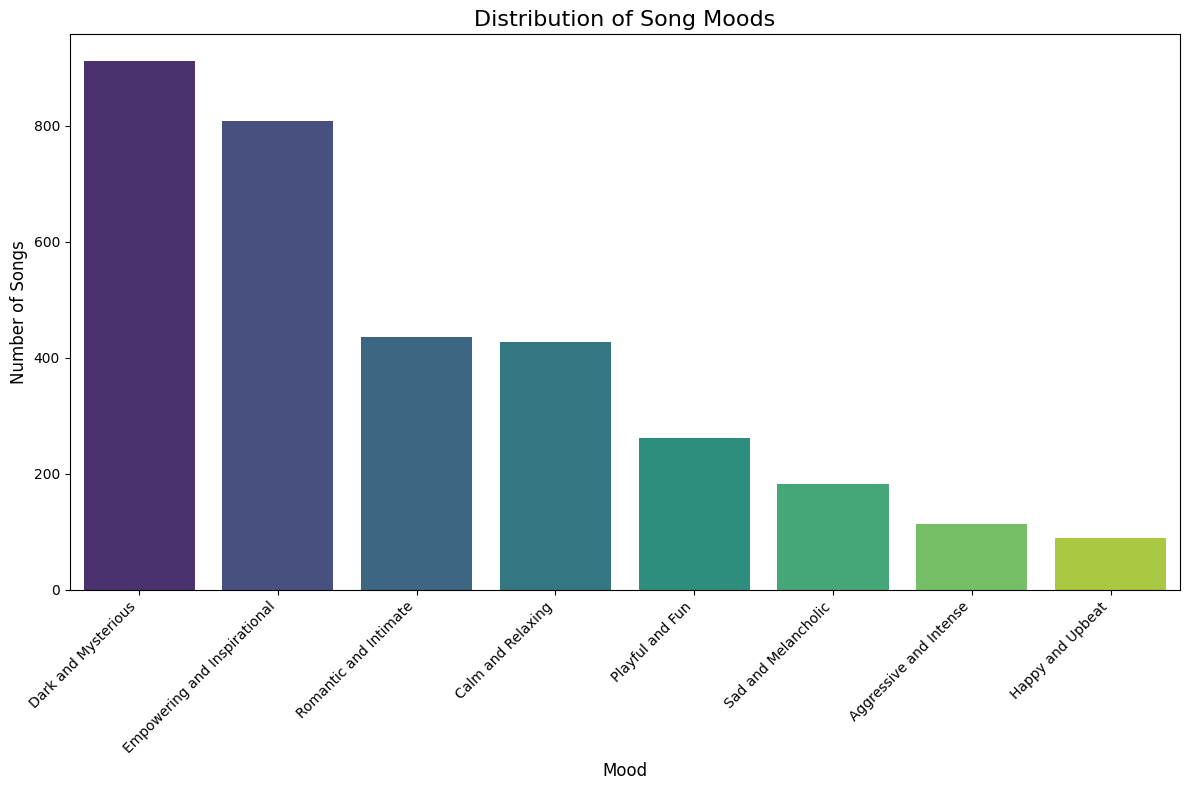

C:\Users\User\AppData\Local\Temp\ipykernel_20724\3917359776.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='mood', y='Track_Popularity', data=df, palette="Set3")


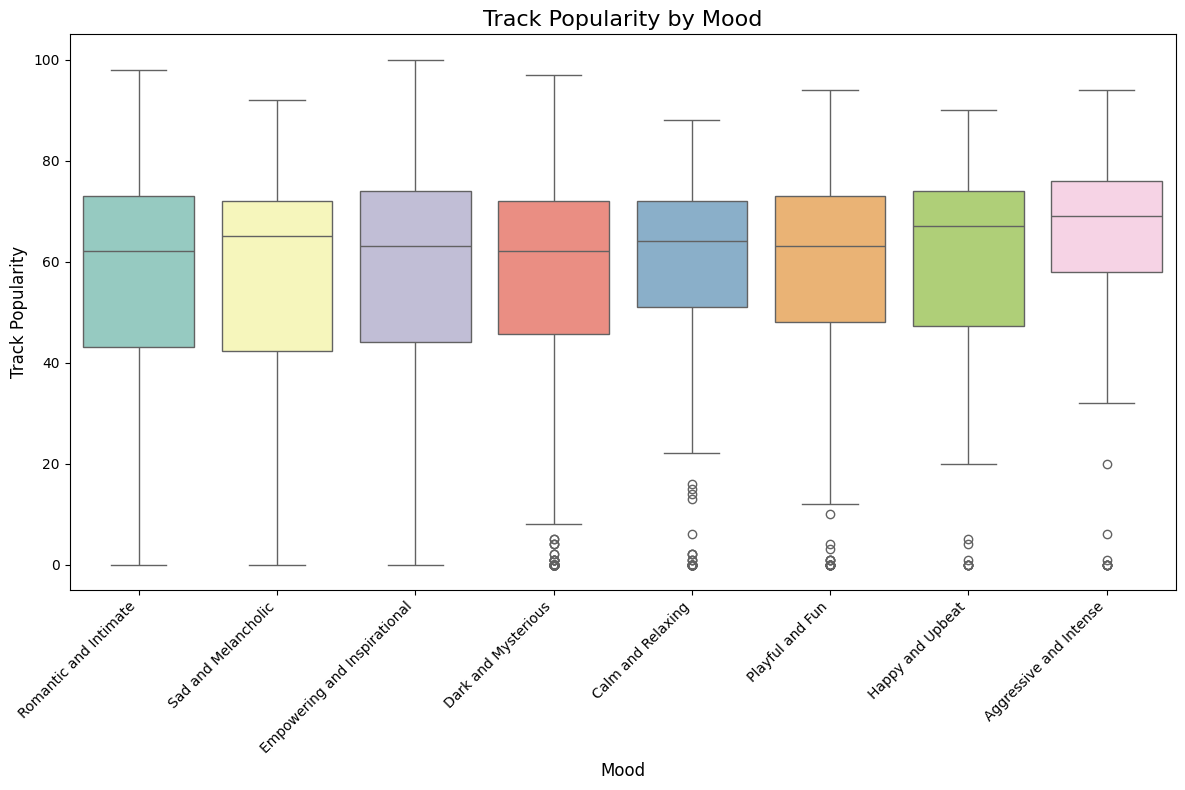

Mood categorization and visualization completed.


In [55]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Load the dataset
df = pd.read_excel('master_final.xlsx')

# 1. Sentiment Analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['Lyrics'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# 2. Topic Modeling with sklearn
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['Lyrics'].astype(str))

# Number of topics
n_topics = 5

lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(doc_term_matrix)

# Get topic distribution for each song
topic_distributions = lda.transform(doc_term_matrix)

# 3. Combine features for clustering
features = np.hstack((df[['Valence', 'Energy', 'Danceability']].values, 
                      df['sentiment'].values.reshape(-1, 1), 
                      topic_distributions))

# 4. Clustering
kmeans = KMeans(n_clusters=8, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# 5. Assign mood labels
mood_labels = [
    "Happy and Upbeat",
    "Sad and Melancholic",
    "Calm and Relaxing",
    "Romantic and Intimate",
    "Dark and Mysterious",
    "Empowering and Inspirational",
    "Aggressive and Intense",
    "Playful and Fun"
]

# Simple mapping based on cluster number
df['mood'] = df['cluster'].map(dict(enumerate(mood_labels)))

# Save the updated dataset
df.to_excel('master_final_with_moods.xlsx', index=False)

# 6. Generate playlists
playlists = {mood: df[df['mood'] == mood][['Title', 'Artist', 'Album']] for mood in mood_labels}

# Print playlists in pretty table format
for mood, playlist in playlists.items():
    print(f"\n{mood} Playlist:")
    table = PrettyTable()
    table.field_names = ["Title", "Artist", "Album"]
    table.align["Title"] = "l"
    table.align["Artist"] = "l"
    table.align["Album"] = "l"
    table.max_width["Title"] = 30
    table.max_width["Artist"] = 20
    table.max_width["Album"] = 30
    
    for _, row in playlist.head(10).iterrows():
        table.add_row([row['Title'], row['Artist'], row['Album']])
    
    print(table)

# Visualization functions
def plot_mood_distribution(df):
    mood_counts = df['mood'].value_counts()
    plt.figure(figsize=(12, 8))
    sns.barplot(x=mood_counts.index, y=mood_counts.values, palette="viridis")
    plt.title('Distribution of Song Moods', fontsize=16)
    plt.xlabel('Mood', fontsize=12)
    plt.ylabel('Number of Songs', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_mood_vs_popularity(df):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='mood', y='Track_Popularity', data=df, palette="Set3")
    plt.title('Track Popularity by Mood', fontsize=16)
    plt.xlabel('Mood', fontsize=12)
    plt.ylabel('Track Popularity', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Generate visualizations
plot_mood_distribution(df)
plot_mood_vs_popularity(df)

print("Mood categorization and visualization completed.")


## Word Clouds for Top 10 Artists by Followers

The below script generates word clouds for the top 10 artists based on their follower count:

- Loads data from 'master_final.xlsx'
- Identifies top 10 artists by follower count
- Creates word clouds of top 20 words from each artist's lyrics
- Displays word clouds in a 5x2 grid
- Shows most used genre for each artist

Key features:
- Uses pandas, matplotlib, and WordCloud
- Removes English stopwords
- Prints top 20 words and genre for each artist
- Creates visual subplots

The output shows word clouds and genre information for artists like Taylor Swift, Ed Sheeran, Billie Eilish and others.


Most used genre for Taylor Swift: pop
Top 20 words: like, i'm, know, got, -, see, 'cause, taylor, back, time, love, made, swift, never, take, look, baby,, go, one, yet?


Most used genre for Ed Sheeran: pop, singer-songwriter pop, uk pop
Top 20 words: -, love, i'm, know, like, come, wanna, (feat., oh,, baby,, my,, go, right, i'll, feel, see, on,, keep, body, could


Most used genre for Billie Eilish: art pop
Top 20 words: i'm, like, know, see, billie, eilish, say, i,, could, wanna, maybe, might, never, love, baby,, think, can't, eyes, me?, 'cause


Most used genre for Ariana Grande: pop
Top 20 words: i'm, love, got, you,, one, like, know, it,, want, 'cause, yeah,, can't, way, baby,, i've, somethin', less, ya, wanna, yeah


Most used genre for The Weeknd: canadian contemporary r&b
Top 20 words: i'm, know, love, like, girl,, got, oh,, baby,, yeah, want, (k+), 'cause, feel, baby, yeah,, make, let, oh, i'll, weeknd


Most used genre for Drake: canadian hip hop
Top 20 words: i'm, know, like

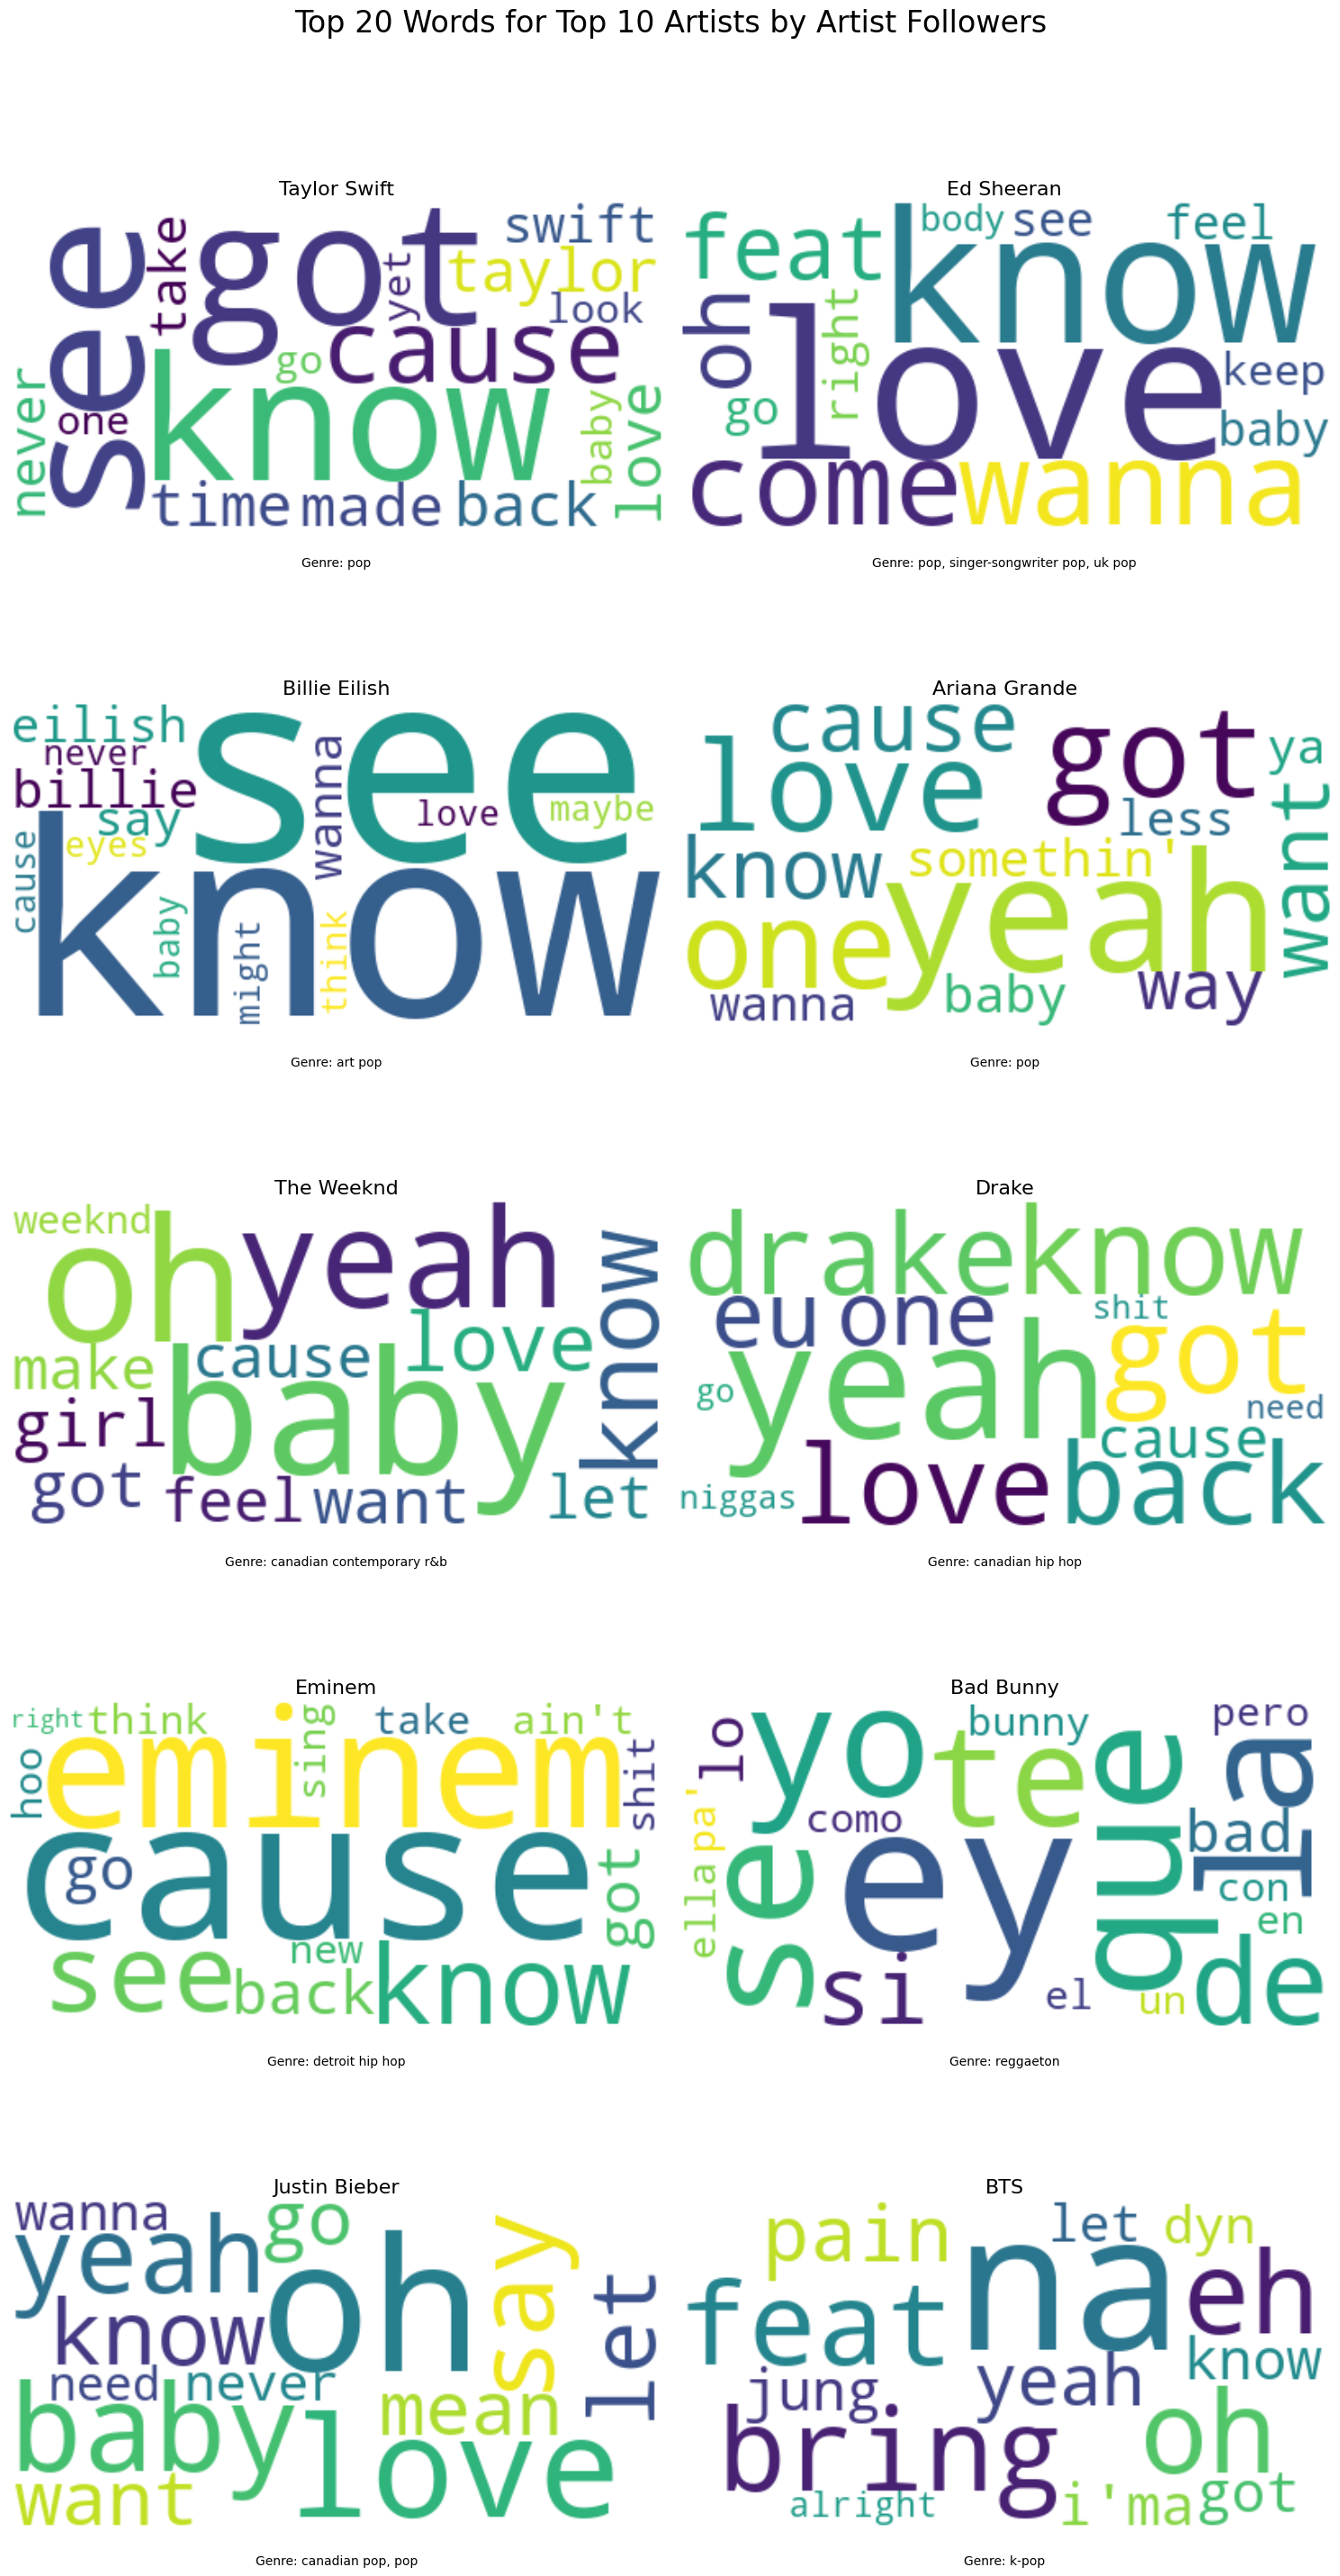

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

# Load the dataset
df = pd.read_excel('master_final.xlsx')

# Get top 10 artists by popularity score
top_10_artists = df.groupby('Artist')['Artist Followers'].mean().nlargest(10).index.tolist()

# Function to process lyrics and get top words
def get_top_words(Lyrics, n=20):
    words = ' '.join(Lyrics).lower().split()
    words = [word for word in words if word not in stopwords.words('english')]
    return [word for word, _ in Counter(words).most_common(n)]

# Create a 5x2 subplot grid
fig, axes = plt.subplots(5, 2, figsize=(15, 30))
fig.suptitle("Top 20 Words for Top 10 Artists by Artist Followers", fontsize=24)

# Create word clouds for top 10 artists
for i, artist in enumerate(top_10_artists):
    artist_data = df[df['Artist'] == artist]
    
    # Get top 20 words
    top_words = get_top_words(artist_data['Lyrics'], 20)
    
    # Create word cloud
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(' '.join(top_words))
    
    # Plot in the appropriate subplot
    row = i // 2
    col = i % 2
    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].axis('off')
    axes[row, col].set_title(f"{artist}", fontsize=16)
    
    # Get most used genre
    most_used_genre = artist_data['Genre'].mode().values[0]
    axes[row, col].text(0.5, -0.1, f"Genre: {most_used_genre}", ha='center', va='center', transform=axes[row, col].transAxes)

    print(f"Most used genre for {artist}: {most_used_genre}")
    print("Top 20 words:", ', '.join(top_words))
    print("\n")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()
